In [255]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

# Beat the Streak - Analysis


The goal of this analysis is to identify factors that correlate with an increase in the probability of a batter getting a hit in a given day. This information will be used to help create better models. 

The data parsing was done in previously. The steps can be seen in notebooks at the [projects github repo](https://github.com/matthewmcnew/beat-the-streak/commits?author=matthewmcnew). Data was pulled from [retrosheet](http://www.retrosheet.org/) and imported into a posgres database using [Chadwick](http://chadwick.sourceforge.net/) and [Py-Retrosheet](https://github.com/wellsoliver/py-retrosheet). 

In the [Build_Choices notebook](https://github.com/matthewmcnew/beat-the-streak/blob/master/Build_Choices.ipynb), retrosheet play day for 2015 was broken into 'choices' for beat the streak. Each choice is a date and batter that is in the starting lineup on that date. Each choice includes data about the batter and the game that they are scheduled to play in. This data is summarized below:

Variable |  Description
---| ---
game_id | ID of game
bat_id | ID of batter
num_hits | Number of Hits in the game
num_singles | Number of the Singles in the game
num_doubles | Number of doubles in the game
num_triples | Number of Triples in the game
num_hrs | Number of HomeRuns in the Game
lineup_pos | Position of the position of the player in the lineup
bat_home_id | 1 if that batter is home 0 if the batter is away
opposing_pitcher_id | ID of the starting pitcher of the opposing team
team_id | ID of the batter's team
opposing_team_id | ID of the opposing team
dh_fl | 1 if a designated hitter is used in the game 0 if not
daynight_park_cd | D if it is a day game. N if it is a night game
park_id | ID of the ballpark the game will be played in 
attend_park_ct | Number of fans in attendance at game
temp_park_ct | Starting temperature of the game
wind_speed_park_ct | Wind Speed at the start of the game
field_park_cd | Field Condition of the game Wet/Dry/Unknown
precip_park_cd | Precipitation of the game Unknown/Drizzle/Rain
sky_park_cd | Sky of the game Unknown/Sunny/Cloudy/Overcast/Dome
bat_hand | Batter's hand L or R
opposing_pit_hand | Opposing Pitcher's Hand L or R

The primary goal of this project will be to predict if a player will get a hit in a game. This variable is calculated as:

Variable |  Description
---| ---
got_hit | 1 if the batter got a hit. 0 if the batter did not.

The [Calculating Averages notebook](https://github.com/matthewmcnew/beat-the-streak/blob/master/Calculating_Averages.ipynb) calculates some additional data about each choice based on previous games in 2015. The data calculated that is used in this analysis is hitting average and it is explained below:

*A hitting average is slightly different that batting average:*

For Batters:
 * Hitting average is the number of hits a batter achieved divided by the number of plate appearances.  
 
![alt text](http://latex.codecogs.com/gif.latex?%5Cfrac%7Bhits%7D%7BplateAppearances%7D "Equation")

For Pitchers:
 * Hitting average is the number of hits from batters faced divided by the number of batters faced
 
![alt text](http://latex.codecogs.com/gif.latex?%5Cfrac%7Bhits%7D%7BbattersFaced%7D "Equation")



Hitting average is calculated for the following scenarios:

* Hitting average of batter in previous games 
* Hitting average of batter against pitchers with the same hand and the starting pitcher in previous games
* Hitting average of starting pitcher in previous games
* Hitting average of starting pitcher against batters with the same batting hand in previous games
* Hitting average of opposing team's bullpen in previous games

In [66]:
import pandas as pd
choices = pd.read_csv('choices.csv')

Without further ado, let's jump into some analysis: 


### Are certain ballparks correlated with a higher probability of a hit?

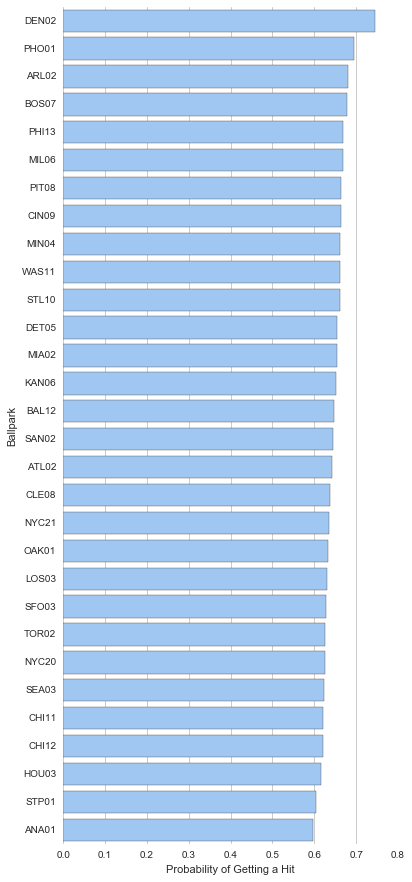

In [247]:
import matplotlib.pyplot as plt
import seaborn as sns

ballparks = choices.groupby('park_id')[['got_hit']].mean().sort_values('got_hit', ascending=False).reset_index()
sns.set(style="whitegrid")
sns.set_color_codes("pastel")

f, ax = plt.subplots(figsize=(6, 15))

sns.barplot(x="got_hit", y="park_id", data=ballparks,
            label="Total", color="b")

ax.set(xlim=(0,.8), ylabel="Ballpark",
       xlabel="Probability of Getting a Hit")

sns.despine(left=True, bottom=True)
plt.show()

As expected, certain ballparks like Denver's Coors Field are more hitter friendly and batters are more likely to get a hit when playing in them.  

This may be because ballparks always feature the home team. However, if we graph the probability of getting a hit for home batters and away batters separately there are still ballparks that have a higher probability of a hit for both home teams and away teams. 

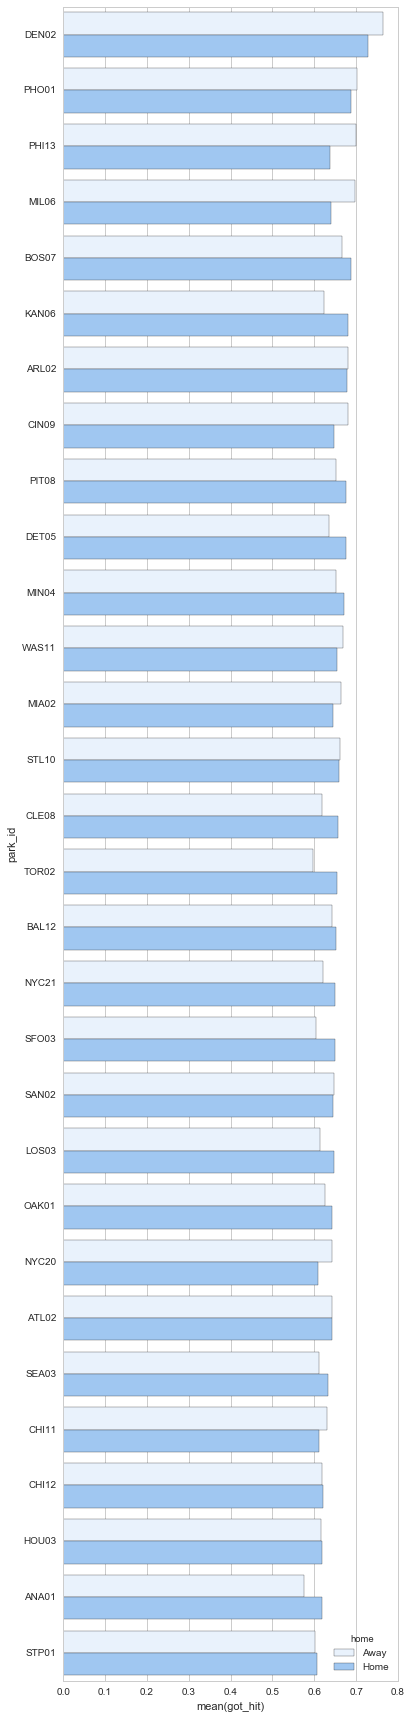

In [252]:
parks = choices.groupby(['park_id', 'bat_home_id'])[['got_hit']].mean().sort_values('got_hit', ascending=False).reset_index()
parks['home'] = parks['bat_home_id'].map({1: 'Home', 0:'Away'})

f, ax = plt.subplots(figsize=(6, 30))
sns.barplot(x="got_hit", y='park_id', hue="home", data=parks,
          color="b")
plt.show()

### Does the time of game matter? (Day/Night)

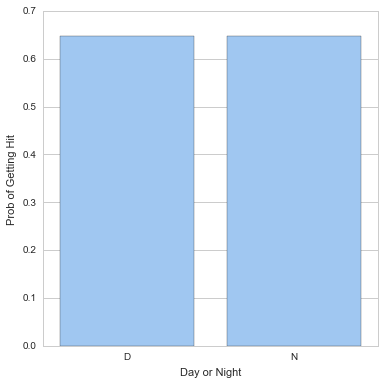

In [185]:
import matplotlib.pyplot as plt
import seaborn as sns

day_night = choices.groupby('daynight_park_cd')[['got_hit']].mean().reset_index()

f, ax = plt.subplots(figsize=(6, 6))
sns.barplot(x="daynight_park_cd", y="got_hit", data=day_night,
            label="Total", color="b")
ax.set(ylabel="Prob of Getting Hit",
       xlabel="Day or Night")
plt.show()

It seems that in general there is not a strong correlation between day or night games and the likelihood of a batter getting a hit. An individual batter might be effected but, as a whole there does not seem to be a pattern. 

### Does the sky condition matter?

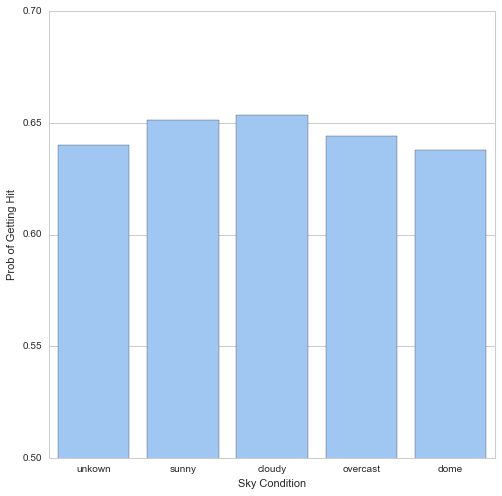

In [219]:
sky = choices.groupby('sky_park_cd')[['got_hit']].mean().reset_index()
sky.sky_park_cd = ['unkown','sunny','cloudy','overcast', 'dome']

f, ax = plt.subplots(figsize=(8, 8))
sns.barplot(x="sky_park_cd", y="got_hit", data=sky,
            label="prob", color="b")
ax.set(ylabel="Prob of Getting Hit", ylim=(.5,.7),
       xlabel="Sky Condition")
plt.show()

### Does temperature matter?

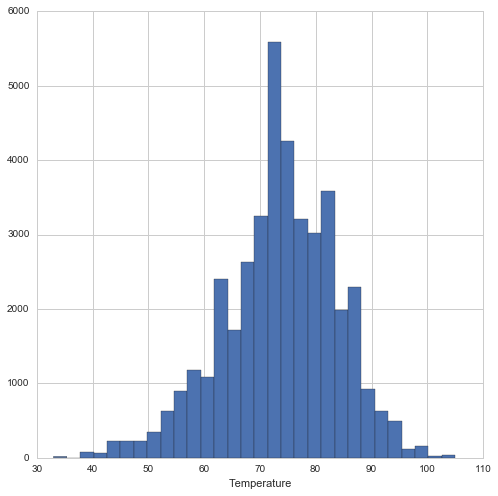

In [222]:
f, ax = plt.subplots(figsize=(8, 8))
choices.temp_park_ct.hist(bins=30)
ax.set(xlabel="Temperature")
plt.show()

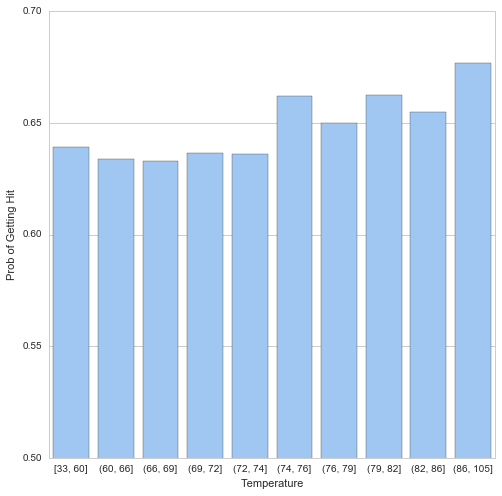

In [223]:
choices['temp_bin'] = pd.qcut(choices.temp_park_ct, 10)

temp = choices.groupby('temp_bin')[['got_hit']].mean().reset_index()

f, ax = plt.subplots(figsize=(8, 8))
sns.barplot(x="temp_bin", y="got_hit", data=temp, label="prob", color="b")
ax.set(ylabel="Prob of Getting Hit", ylim=(.5,.7), xlabel="Temperature")
plt.show()

### Does wind speed matter?

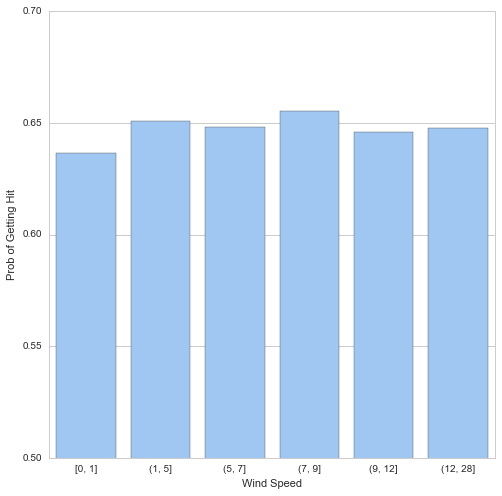

In [186]:
choices['wind_speed_park_ct'] = [float(w) for w in choices.wind_speed_park_ct]

choices['wind_bin'] = pd.qcut(choices.wind_speed_park_ct, 6)

wind = choices.groupby('wind_bin')[['got_hit']].mean().reset_index()

f, ax = plt.subplots(figsize=(8, 8))
sns.barplot(x="wind_bin", y="got_hit", data=wind, label="prob", color="b")
ax.set(ylabel="Prob of Getting Hit", ylim=(.5,.7), xlabel="Wind Speed")
plt.show()

### Does attendance matter?

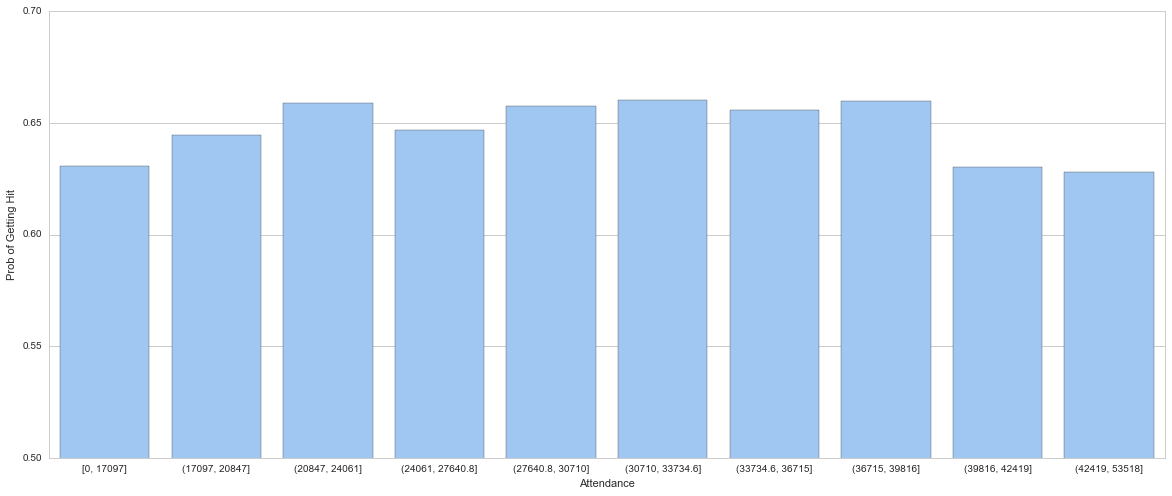

In [221]:
choices['attnd_bin'] = pd.qcut(choices.attend_park_ct, 10)

temp = choices.groupby('attnd_bin')[['got_hit']].mean().reset_index()

f, ax = plt.subplots(figsize=(20, 8))
sns.barplot(x="attnd_bin", y="got_hit", data=temp, label="prob", color="b")
ax.set(ylabel="Prob of Getting Hit", ylim=(.5,.7), xlabel="Attendance")
plt.show()

### Does the field condition matter?

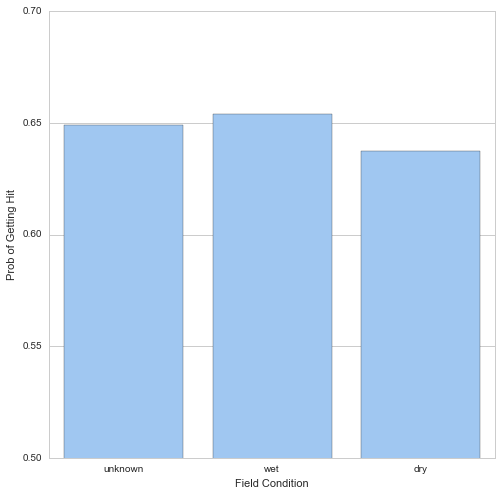

In [220]:

field = choices.groupby('field_park_cd')[['got_hit']].mean().reset_index()
field.field_park_cd = ['unknown', 'wet', 'dry']
f, ax = plt.subplots(figsize=(8, 8))
sns.barplot(x="field_park_cd", y="got_hit", data=field, label="prob", color="b")
ax.set(ylabel="Prob of Getting Hit", ylim=(.5,.7), xlabel="Field Condition")
plt.show()

### How does the past performance of hitters and starting pitchers effect the probability?

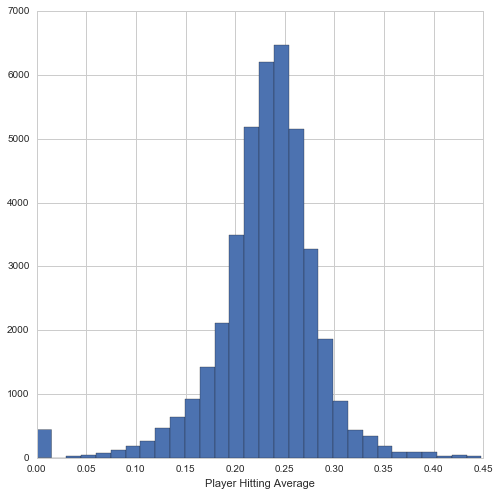

In [189]:
f, ax = plt.subplots(figsize=(8, 8))
choices[choices['hitting_average'] < .45].hitting_average.hist(bins=30)
ax.set(xlabel="Player Hitting Average")
plt.show()

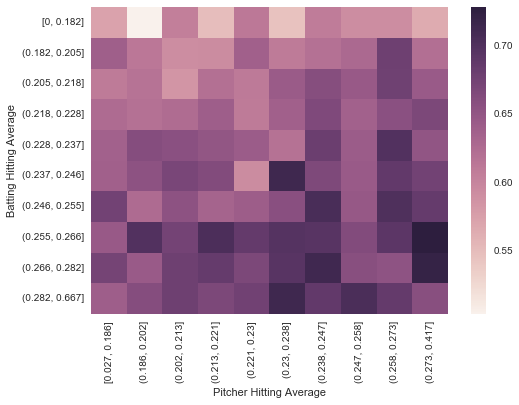

In [190]:
narrowed_choices = choices[choices['total_batter_appearances'] > 10]
narrowed_choices = narrowed_choices[narrowed_choices['total_pitcher_appearances'] > 30]

narrowed_choices['batting_bin'] = pd.qcut(narrowed_choices.hitting_average, 10)
narrowed_choices['pitcher_bin'] = pd.qcut(narrowed_choices.pitcher_hitting_average, 10)

import numpy as np
pitcher_batter_pivot = pd.pivot_table(data=narrowed_choices, values='got_hit', index='batting_bin', columns='pitcher_bin', aggfunc=np.mean)

import seaborn as sns
ax = sns.heatmap(pitcher_batter_pivot)
ax.set(xlabel="Pitcher Hitting Average", ylabel="Batting Hitting Average")
plt.show()

It seems that the past performance of players is at least slightly indicative of the probability of a player getting a hit. 

In the heatmap above, the bottom right boxes represent players who get alot of hits and are facing pitchers that give up alot of hits. This corner is darker indicating that a player is likely to get a hit in this scenario.

In the top left, these boxes represent players who get very few hits and are facing pitchers that give up very few hits. These boxes are lighter indicating that a player is less likely to get a hit in this scenario. 


### How does the bullpen effect the probability?

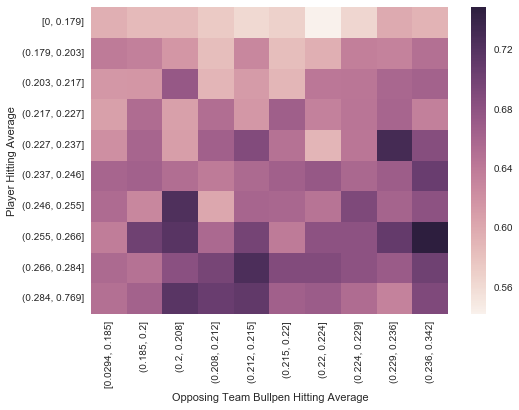

In [191]:
narrowed_choices = choices[choices['total_batter_appearances'] > 10]
narrowed_choices = narrowed_choices[narrowed_choices['bullpen_appearances'] > 30]

narrowed_choices['batting_bin'] = pd.qcut(narrowed_choices.hitting_average, 10)
narrowed_choices['bullpen_bin'] = pd.qcut(narrowed_choices.bullpen_average, 10)

import numpy as np
pitcher_batter_pivot = pd.pivot_table(data=narrowed_choices, values='got_hit', index='batting_bin', columns='bullpen_bin', aggfunc=np.mean)

import seaborn as sns
ax = sns.heatmap(pitcher_batter_pivot)
ax.set(xlabel="Opposing Team Bullpen Hitting Average", ylabel="Player Hitting Average")
plt.show()

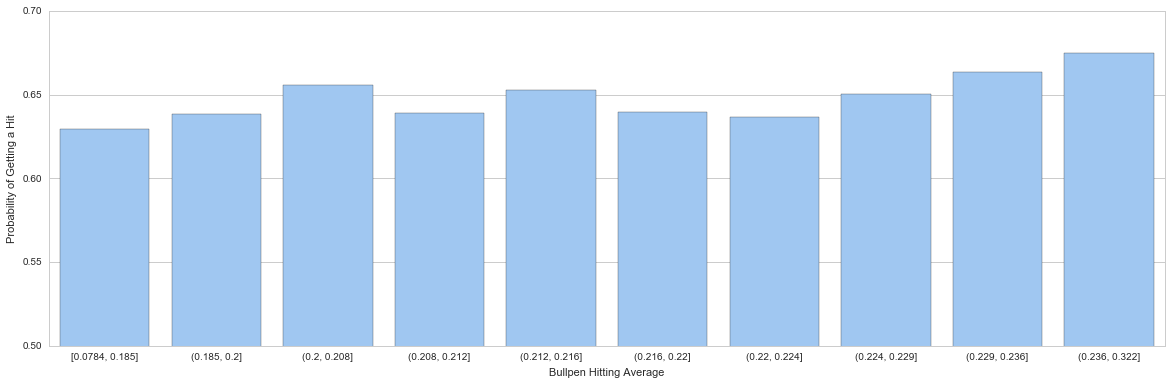

In [192]:
narrowed_choices = choices[choices['bullpen_appearances'] > 50]
narrowed_choices = narrowed_choices.copy()
narrowed_choices['bullpen_bin'] = pd.qcut(narrowed_choices.bullpen_average, 10)
bullpen = narrowed_choices.groupby('bullpen_bin')[['got_hit']].mean().reset_index()
bullpen
f, ax = plt.subplots(figsize=(20, 6))
sns.barplot(x="bullpen_bin", y="got_hit", data=bullpen,
            label="Total", color="b")

ax.set(xlabel="Bullpen Hitting Average", ylabel="Probability of Getting a Hit", ylim=(0.5,0.7))
plt.show()

In [206]:
print "Bullpen Hitting Average Correlation"
choices[['got_hit', 'bullpen_average']].corr()[['got_hit']]

Bullpen Hitting Average Correlation


,got_hit
got_hit,1.000000
bullpen_average,0.028854


It looks like there is an increase in the likelihood of getting a hit when batters face teams with bullpens that give up more hits. 

### Does the batters batting hand or the pitchers throwing hand matter?

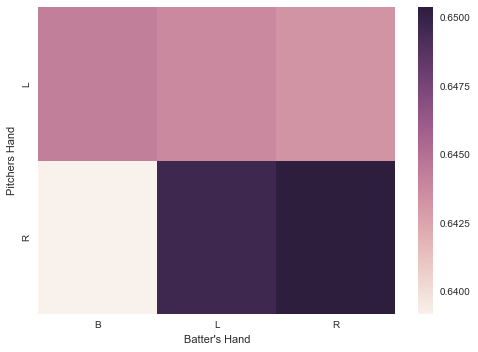

In [193]:
pt = pd.pivot_table(data=choices, values='got_hit', index='pit_hand_cd', columns='bat_hand', aggfunc=np.mean)
ax = sns.heatmap(pt)
ax.set(xlabel="Batter's Hand", ylabel="Pitchers Hand")
plt.show()

### Does it matter if the starting pitcher gives up more hits to the batters with the batter's hand?

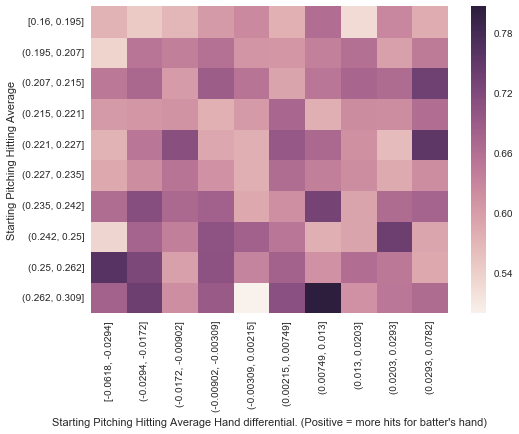

In [194]:
narrowed_choices = choices[choices['hand_pitcher_appearances'] > 200]
narrowed_choices = narrowed_choices.copy()
narrowed_choices['pitcher_against_hand_diff'] = narrowed_choices['hand_pitcher_hitting_average'] - narrowed_choices['pitcher_hitting_average']

narrowed_choices['pitching_bin'] = pd.qcut(narrowed_choices.pitcher_hitting_average, 10)
narrowed_choices['pitcher_against_hand_diff_bin'] = pd.qcut(narrowed_choices.pitcher_against_hand_diff, 10)

pt = pd.pivot_table(data=narrowed_choices, values='got_hit', index='pitching_bin', columns='pitcher_against_hand_diff_bin', aggfunc=np.mean)
ax = sns.heatmap(pt)

ax.set(xlabel="Starting Pitching Hitting Average Hand differential. (Positive = more hits for batter's hand)", ylabel="Starting Pitching Hitting Average")
plt.show()

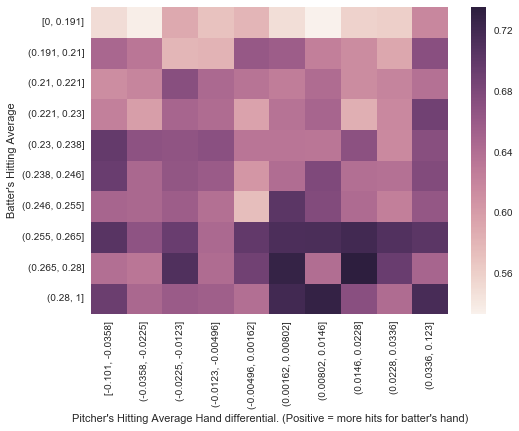

In [195]:
narrowed_choices = choices[choices['hand_pitcher_appearances'] > 100]
narrowed_choices = narrowed_choices.copy()
narrowed_choices['pitcher_against_hand_diff'] = narrowed_choices['hand_pitcher_hitting_average'] - narrowed_choices['pitcher_hitting_average']

narrowed_choices['hitting_bin'] = pd.qcut(narrowed_choices.hitting_average, 10)
narrowed_choices['pitcher_against_hand_diff_bin'] = pd.qcut(narrowed_choices.pitcher_against_hand_diff, 10)

pt = pd.pivot_table(data=narrowed_choices, values='got_hit', columns='pitcher_against_hand_diff_bin', index='hitting_bin', aggfunc=np.mean)
ax = sns.heatmap(pt)

ax.set(xlabel="Pitcher's Hitting Average Hand differential. (Positive = more hits for batter's hand)", ylabel="Batter's Hitting Average")
plt.show()

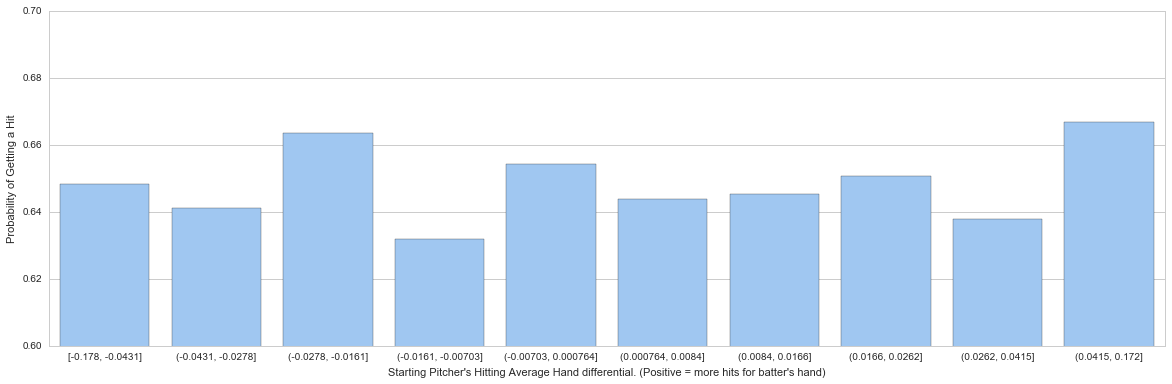

In [196]:
narrowed_choices = choices[choices['hand_pitcher_appearances'] > 40]
narrowed_choices = narrowed_choices.copy()
narrowed_choices['pitcher_against_hand_diff'] = narrowed_choices['hand_pitcher_hitting_average'] - narrowed_choices['pitcher_hitting_average']
narrowed_choices['pitcher_against_hand_diff_bin'] = pd.qcut(narrowed_choices.pitcher_against_hand_diff, 10)
pitchers_hand_diff = narrowed_choices.groupby(['pitcher_against_hand_diff_bin']).got_hit.mean().reset_index()

f, ax = plt.subplots(figsize=(20, 6))
plt.ylim(.6, .7)
sns.barplot(data=pitchers_hand_diff, x='pitcher_against_hand_diff_bin', y='got_hit', color="b")

ax.set(xlabel="Starting Pitcher's Hitting Average Hand differential. (Positive = more hits for batter's hand)", ylabel="Probability of Getting a Hit")
plt.show()

In [207]:
narrowed_choices = choices[choices['hand_pitcher_appearances'] > 40]
narrowed_choices = narrowed_choices.copy()
narrowed_choices['pitcher_against_hand_diff'] = narrowed_choices['hand_pitcher_hitting_average'] - narrowed_choices['pitcher_hitting_average']

print "Starting Po"
narrowed_choices[['got_hit', 'pitcher_against_hand_diff']].corr()[['got_hit']]

Bullpen Hitting Average Correlation


,got_hit
got_hit,1.000000
pitcher_against_hand_diff,0.003411


It looks like there might be a very slight increase in the likelihood of getting a hit when batters face starting pitchers that give up more hits to the batters hand. 

### Does it matter if the batter gets more hits from pitchers with the starting pitchers throwing hand?

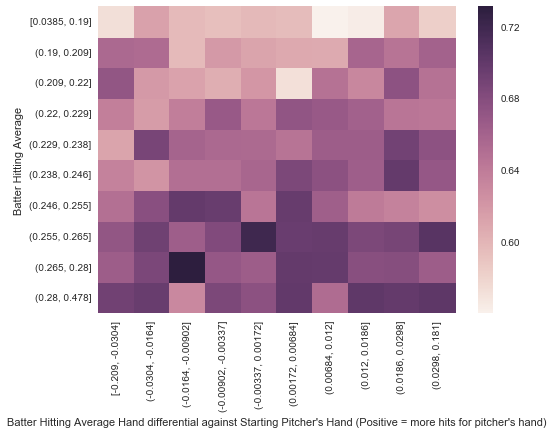

In [197]:
narrowed_choices = choices[choices['hand_batter_appearances'] > 30]
narrowed_choices = narrowed_choices.copy()
narrowed_choices['batter_hand_diff'] = narrowed_choices['hand_hitting_average'] - narrowed_choices['hitting_average'] 

narrowed_choices['batter_bin'] = pd.qcut(narrowed_choices.hitting_average, 10)
narrowed_choices['batter_hand_diff_bin'] = pd.qcut(narrowed_choices.batter_hand_diff, 10)

pt = pd.pivot_table(data=narrowed_choices, values='got_hit', index='batter_bin', columns='batter_hand_diff_bin', aggfunc=np.mean)
ax = sns.heatmap(pt)

ax.set(xlabel="Batter Hitting Average Hand differential against Starting Pitcher's Hand (Positive = more hits for pitcher's hand)", ylabel="Batter Hitting Average")
plt.show()

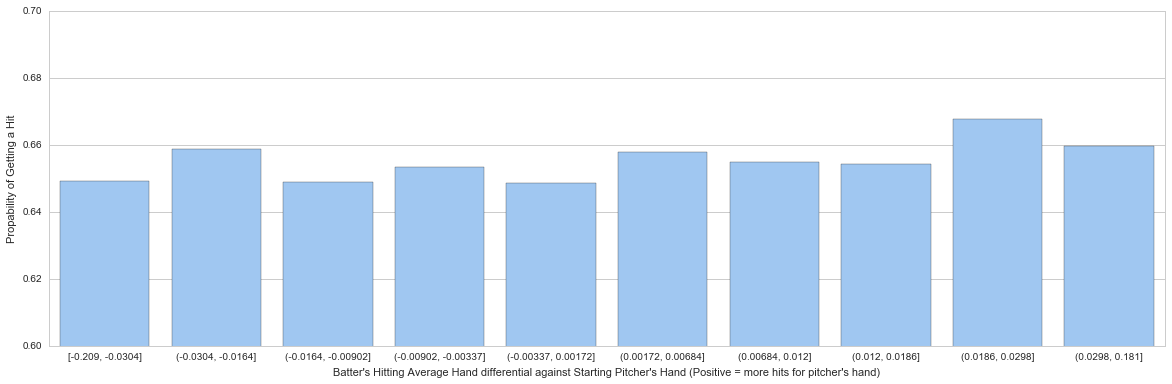

In [253]:
narrowed_choices = choices[choices['hand_batter_appearances'] > 30]
narrowed_choices = narrowed_choices.copy()
narrowed_choices['batter_hand_diff'] = narrowed_choices['hand_hitting_average'] - narrowed_choices['hitting_average'] 

narrowed_choices['batter_hand_diff_bin'] = pd.qcut(narrowed_choices.batter_hand_diff, 10)

batter_hand_diffs = narrowed_choices.groupby('batter_hand_diff_bin').got_hit.mean().reset_index()

f, ax = plt.subplots(figsize=(20, 6))
plt.ylim(.6, .7)
sns.set(style="whitegrid")
sns.barplot(data=batter_hand_diffs, x='batter_hand_diff_bin', y='got_hit', color='B')

ax.set(xlabel="Batter's Hitting Average Hand differential against Starting Pitcher's Hand (Positive = more hits for pitcher's hand)", ylabel="Propability of Getting a Hit")
plt.show()

In [214]:
narrowed_choices = choices[choices['hand_batter_appearances'] > 30]
narrowed_choices = narrowed_choices.copy()
narrowed_choices['batter_hand_diff'] = narrowed_choices['hand_hitting_average'] - narrowed_choices['hitting_average']

narrowed_choices[['got_hit', 'batter_hand_diff']].corr()[['got_hit']]

,got_hit
got_hit,1.000000
batter_hand_diff,0.006459


It looks like there might be a very slight increase in the likelihood of getting a hit when batters face a pitcher with the starting hand they get more hits from. 

### Do walk percentages matter?

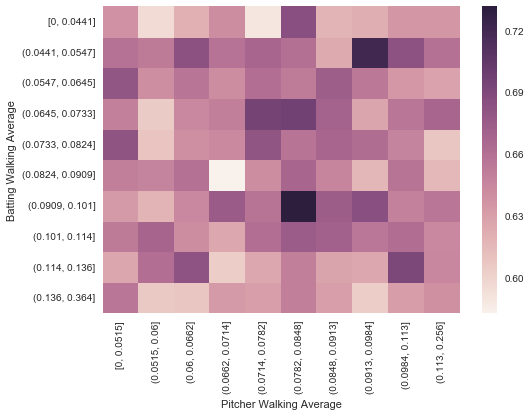

In [199]:
narrowed_choices = choices[choices['total_batter_appearances'] > 10]
narrowed_choices = narrowed_choices[narrowed_choices['total_pitcher_appearances'] > 30]

narrowed_choices['batting_bin'] = pd.qcut(narrowed_choices.walking_average, 10)
narrowed_choices['pitcher_bin'] = pd.qcut(narrowed_choices.pitcher_walking_average, 10)

import numpy as np
pitcher_batter_pivot = pd.pivot_table(data=narrowed_choices, values='got_hit', index='batting_bin', columns='pitcher_bin', aggfunc=np.mean)

import seaborn as sns
ax = sns.heatmap(pitcher_batter_pivot)
ax.set(xlabel="Pitcher Walking Average", ylabel="Batting Walking Average")
plt.show()

In [254]:
choices[['got_hit', 'pitcher_walking_average','walking_average']].corr()[['got_hit']]

,got_hit
got_hit,1.000000
pitcher_walking_average,0.002021
walking_average,-0.011630


It doesn't look there are any strong correlations with walk percentages. 